# "Where Is Forest Loss Happening?" Widget

This widget is a mix of a donut chart and a ranked list. It shows tree cover loss by admin region. On hover the pie chart segments display the loss, in ha, for that region.

The time period over which the loss is shown is controlled by the user in the settings. By default it will be set to cover the whole data period (e.g. 2001 - 2016).

The donut chart should display data for the top few admin regions, and group the rest together as 'Other Districts'.

Data:

1. admn-1 and -2 codes
2. forest loss
3. extent

User Variables:

1. year range
2. unit (ha/% of regions extent)
3. locations (all)
4. canopy threshold


In [1]:
#Import Global Metadata etc

%run '0.Importable_Globals.ipynb'

In [2]:
# VARIABLES
location = 'All Region'
thresh = 30
adm0 = 'BRA'
adm1 = None
extent_year = 2000     #extent data (2000 or 2010)
start = 2001     
end = 2016


tags = ["forest_change"]
selectable_polynames = ['gadm28',
                        'mining',
                        'plantations']

In [3]:
# get admin 1 or 2 level human-readable name info as needed:
adm1_to_name = None
adm2_to_name = None

if adm1:
    
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    adm2_to_name ={}
    for row in tmp:
        adm2_to_name[row.get('adm2')] = row.get('name')

tmp = get_admin1_json(iso=adm0)
adm1_to_name={}
for row in tmp:
    adm1_to_name[row.get('adm1')] = row.get('name') 

In [4]:
def loss_by_multiregion(p_name, adm0, adm1=None, threshold=30):
    if adm1:
        print('Request for  admin-1 areas')
        sql = (f"SELECT adm2, year_data.year as year, "
               f"SUM(year_data.area_loss) as area_loss, "
               f"FROM data "
               f"WHERE polyname = '{p_name}' "
               f"AND iso = '{adm0}' "
               f"AND adm1 = {adm1} AS region"
               f"AND thresh= {threshold} "
               f"GROUP BY adm2, nested(year_data.year)"
               f"ORDER BY adm2")
        return sql
    elif adm0:
        print('Request for  national area')
        sql = (f"SELECT adm1 AS region, year_data.year as year, "
               f"SUM(year_data.area_loss) as area_loss, "
               f"FROM data "
               f"WHERE polyname = '{p_name}' " 
               f"AND iso = '{adm0}' "
               f"AND thresh= {threshold} "
               f"GROUP BY adm1 nested(year_data.year)"
               f"ORDER BY adm1")
        return sql


In [5]:
# Returns json object containing admin-codes, total area and extent (both in ha)
# If adm1 is not specified, it returns the total values for each adm1 region
# Else, returns the adm2 values within that adm1 region
# You may also specify a polyname (intersecting area) e.g. 'extent and % of plantations only'
# By default polyname is 'gadm28' (all forest extent)

def multiregion_extent_queries(adm0, adm1=None, year='area_extent_2000', p_name='gadm28', threshold=30):
    if adm0 and not adm1:
        print('Request for adm1 areas')
        sql = (f"SELECT adm1 as region, sum({year}) as extent, sum(area_gadm28) as total "
               f"FROM {ds} "
               f"WHERE iso = '{adm0}' "
               f"AND thresh = {threshold} "
               f"AND polyname = '{p_name}' "
               f"GROUP BY adm1 "
               f"ORDER BY adm1")
    elif adm0 and adm1:
        print('Request for adm2 areas')
        sql = (f"SELECT adm2 as region, {year} as extent, area_gadm28 as total "
                f"FROM {ds} "
                f"WHERE iso = '{adm0}' "
                f"AND thresh = {threshold} "
                f"AND polyname = '{p_name}' "
                f"AND adm1 = '{adm1}' ")
    return sql

In [6]:
# Query for loss

url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
loss_sql = loss_by_multiregion(p_name=polynames[location], adm0=adm0, adm1=adm1, threshold=thresh)

properties = {"sql": loss_sql}
rl = requests.get(url, params = properties)
print(rl.url)
print(f'Status: {rl.status_code}')

loss_data = rl.json()['data']

#Example data structure
loss_data[0:3]

Request for  national area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+adm1+AS+region%2C+year_data.year+as+year%2C+SUM%28year_data.area_loss%29+as+area_loss%2C+FROM+data+WHERE+polyname+%3D+%27gadm28%27+AND+iso+%3D+%27BRA%27+AND+thresh%3D+30+GROUP+BY+adm1+nested%28year_data.year%29ORDER+BY+adm1
Status: 200


[{'area_loss': 67298, 'region': 1, 'year': 2001},
 {'area_loss': 68427, 'region': 1, 'year': 2002},
 {'area_loss': 37653, 'region': 1, 'year': 2003}]

In [7]:
#Query for extent (to calculate percentages)

url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
extent_sql = multiregion_extent_queries(adm0=adm0, adm1=adm1, year=extent_year_dict[extent_year],
                                        p_name=polynames[location], threshold=thresh)

properties = {"sql": extent_sql}
re = requests.get(url, params = properties)
print(re.url)
print(f'Status: {re.status_code}')

extent_data = re.json()['data']

#Example data structure
extent_data[0:3]

Request for adm1 areas
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+adm1+as+region%2C+sum%28area_extent_2000%29+as+extent%2C+sum%28area_gadm28%29+as+total+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27gadm28%27+GROUP+BY+adm1+ORDER+BY+adm1
Status: 200


[{'extent': 14379381.2578125, 'region': 1, 'total': 15273286.984375},
 {'extent': 582992.8784446716, 'region': 2, 'total': 2775822.3068847656},
 {'extent': 12186407.07421875, 'region': 3, 'total': 14221825.859375}]

In [8]:
# for a specified start and an end year, end up with a json of admin_ID, and loss

# Find out the unique list of regions in the returned array
unique_regions = []
for row in loss_data:
    #print(row)
    tmp_region = row.get('region', None)
    if tmp_region not in unique_regions:
        unique_regions.append(tmp_region)
        
# Loop over that list of regions
loss_json = []
for region in unique_regions:
    tmp_loss = 0
    # gather all yearly data from the loss json object
    for row in loss_data:
        tmp_region = row.get('region', None)
        if tmp_region == region:
            if row.get('year', None) >= start and row.get('year', None) <= end:
                tmp_loss += row.get('area_loss', 0)
    # gather extent data from the extent json object
    tmp_extent = 0
    for row in extent_data:
        if row.get('region') == region:          
            tmp_extent = row.get('extent', None)
            break
    loss_in_percent = tmp_loss/tmp_extent * 100
    loss_json.append({'region':region,'area_loss_ha': tmp_loss, 'area_loss_%':loss_in_percent})
    #print(f"{areaId_to_name[region]} loss between {start} and {end} is {tmp_loss:,.0f}ha or {loss_in_percent:3.2f}%")

loss_json[0:3]

[{'area_loss_%': 6.7476130064556346, 'area_loss_ha': 970265, 'region': 1},
 {'area_loss_%': 11.533760100018348, 'area_loss_ha': 67241, 'region': 2},
 {'area_loss_%': 2.1031711679993346, 'area_loss_ha': 256301, 'region': 3}]

In [9]:
#Sort regions by area of loss (DESC)

newlist = sorted(loss_json, key=lambda k: k['area_loss_ha'], reverse=True) 
newlist[0]

{'area_loss_%': 10.30120581962279, 'area_loss_ha': 11189694, 'region': 14}

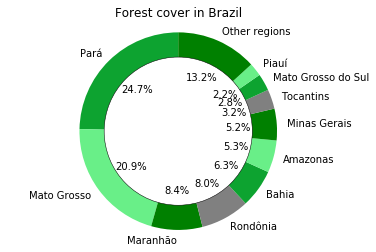

In [10]:
# Example donut chart 
# NOTE - THE COLOURS ARE NOT NECESSARILY THOSE NEEDED FOR PRODUCTION
  
limit = 0
sizes = []
labels = [] 

for r in range(0,10):
    
    try:
        if adm1:
            labels.append(adm2_to_name[newlist[r].get('region')])
        elif adm0:
            labels.append(adm1_to_name[newlist[r].get('region')])
        sizes.append(newlist[r].get('area_loss_ha'))
        
    except:
        break
    limit += 1
      
other_regions=0

for rows in range(limit+1,len(newlist)):
    other_regions += newlist[rows].get('area_loss_ha')

if other_regions != 0:
    labels.append('Other regions')
    sizes.append(other_regions)
            
if adm1:
    title = adm1_to_name[adm1]
elif adm0:
    title = iso_to_countries[adm0]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['#0da330', '#69ef88','green','grey'])
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.title(f'Forest cover in {title}')
plt.show()

<a id='s12'></a>
### Dynamic Sentence for Loss widget

1. Returns the no of regions responsible for >50% of the regions tree cover loss (adm1)
     - or, the loss (%) that the top 10% of regions are responsible for (adm2)
2. Max and Min loss (%) in that region
3. Average loss (%) that each region contributes to the total

In [11]:
#Calculate total three cover loss at this threshold
total = 0

for i in range(0,len(loss_json)):
    total += newlist[i]['area_loss_ha']

In [12]:
# Calculate % loss for the region (relative to total loss). Also filters out incorrect/duplicated data

correct_list = []
for i in range(0,len(loss_json)):
    if(i != 0 and newlist[i]['region'] != newlist[i-1]['region']):
        correct_list.append(100*newlist[i]['area_loss_ha']/total)
    elif i == 0:
        correct_list.append(100*newlist[i]['area_loss_ha']/total)
correct_list[0:3]

[24.15413792096347, 20.473648183396183, 8.20261554374448]

In [13]:
#Calculate the mean loss

mean=0
for i in range(0, len(correct_list)):
    
    mean += correct_list[i]
    
mean = mean/len(correct_list)

In [14]:
correct_list[0:5]

[24.15413792096347,
 20.473648183396183,
 8.20261554374448,
 7.817604461786299,
 6.1367845007098465]

In [15]:
# Percentile calcs: work out how many regions are responsible for >50% loss
# x is no. of adm regions.

if adm1:
    top_ten_index = int(len(correct_list)/10)
    total = np.sum(correct_list[0: top_ten_index+1])
     
accumulated_percent = 0
for n, item in enumerate(correct_list):
    accumulated_percent += item
    if accumulated_percent >= 50:
        lower_fity_percentile_regions = n +1
        break

In [16]:
#Loss Stats
loss_stats = { 'max': correct_list[0], 'min': correct_list[len(correct_list)-1], 'avg': mean}
loss_stats

{'avg': 3.7037037037037037,
 'max': 24.15413792096347,
 'min': 0.0049626346422248025}

In [23]:
#Dynamic sentence. For adm2.

if adm1:
    if len(correct_list) > 10:
        print(f"The top ten percent of sub-regions were responsible for ", end="")
        print(f"{total:,.0f}% of {areaId_to_name[adm1]}'s total tree cover loss ", end="")

        if location == 'All Region':
            print(f"across the region ", end="")
        elif (location == 'Mining' or 'Mining in Intact Forest Landscapes' or 'Mining in Plantation Areas'):
             print(f"in areas with {location.lower()} ", end="")
        else:
            print(f"found in {location.lower()} ", end="")

    print(f"where canopy is greater than {thresh}%. ", end="")
    print(f"{adm2_to_name[newlist[0].get('region')]} experienced the largest relative tree cover loss ", end="")
    print(f"in {adm1_to_name[adm1]} relative to extent in {extent_year}, at {loss_stats['max']:,.0f}% compared to an average ", end="")
    print(f"of {loss_stats['avg']:,.1f}%. ", end="")
    
else:
    
#Dynamic sentence. For adm1.
    if len(correct_list) > 10:
        print(f"In {iso_to_countries[adm0]} {lower_fity_percentile_regions} ", end="")
        print(f"regions were responsible for more than half ({accumulated_percent:,.0f}%) ",end="")

        print(f"of all tree cover loss ", end="")
        if location == 'All Region':
            print(f"country-wide ", end="")
        elif (location == 'Mining' or 'Mining in Intact Forest Landscapes' or 'Mining in Plantation Areas'):
            print(f"in areas with {location.lower()} ", end="")
        else:
            print(f"found in {location.lower()} ", end="")
            
    print(f"where canopy is greater than {thresh}%. ", end="")
    print(f"{adm1_to_name[newlist[0].get('region')]} has the largest relative tree cover loss ", end="")
    print(f"in {iso_to_countries[adm0]} relative to extent in {extent_year}, at {loss_stats['max']:,.0f}% compared to an average ", end="")
    print(f"of {loss_stats['avg']:,.1f}%. ", end="")

In Brazil 3 regions were responsible for more than half (53%) of all tree cover loss country-wide where canopy is greater than 30%. Pará has the largest relative tree cover loss in Brazil relative to extent in 2000, at 24% compared to an average of 3.7%. 